# Electricity Load Prediction using Deep LSTM

Importing necessary libraries

In [27]:
#pip install tensorflow

In [28]:
#pip install workalendar

In [29]:
import datetime
import json
import os
# from joblib import Parallel, delayed
from time import sleep, time
import logging
import random

import tensorflow as tf
import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import seaborn as sns
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout, Input
from matplotlib import rcParams  # Used to set default paremeters

from sklearn.preprocessing import MinMaxScaler
from workalendar.europe import UnitedKingdom

from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error, r2_score
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

In [30]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Default Parameters

In order to save time and avoid having to set the parameters for each plot, I will define the default font and font sizes for all the plots.

In [31]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

# Loading Data

Quebec historic electricity demand between 2019 and 2023.

In [32]:
df= pd.read_csv("HQ_LOAD_hourly_2019_2023.csv", header=0, index_col=0, parse_dates=True)
df

,Moyenne (MW)
Date,
2019-01-01 01:00:00,23762.55
2019-01-01 02:00:00,23830.23
2019-01-01 03:00:00,23608.07
2019-01-01 04:00:00,23562.48
2019-01-01 05:00:00,23546.16
...,...
2023-12-31 19:00:00,28620.17
2023-12-31 20:00:00,27841.33
2023-12-31 21:00:00,27101.44


# Data understanding

In [33]:
df.describe()

,Moyenne (MW)
count,43778.000000
mean,21544.742958
std,5193.797252
min,13293.750000
25%,17705.092500
50%,19809.570000
75%,25425.177500
max,42472.830000


In [34]:
df.shape

(43823, 1)

In [35]:
df.index.is_monotonic_increasing

False

Let's sort the values by date as some of them have been misplaced in the original dataset

In [36]:
df = df.sort_index()

# Data preparation

In [37]:
column_selection = "Moyenne (MW)"

In [38]:
df=df[column_selection].to_frame()

Check for duplicates.

In [39]:
df[df.index.duplicated()]

,Moyenne (MW)
Date,
2019-11-03 01:00:00,17963.20
2020-11-01 01:00:00,20001.77
2021-11-07 01:00:00,18685.38
2022-11-06 01:00:00,14447.54
2023-01-01 00:00:00,22945.84
2023-11-05 01:00:00,18821.29


In [40]:
unique, counts = np.unique(df.index.duplicated(), return_counts=True)

In [41]:
dict(zip(unique, counts))

{False: 43817, True: 6}

There are 6 Hours in the index that are duplicated in the data set. The duplicated data is replaced by the mean of the duplicates.

In [42]:
df=df.groupby(level=0).mean()

Check for missing data

In [43]:
pd.date_range(df.index.min(), df.index.max(), freq="y").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [44]:
pd.date_range(df.index.min(), df.index.max(), freq="m").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [45]:
pd.date_range(df.index.min(), df.index.max(), freq="d").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [46]:
pd.date_range(df.index.min(), df.index.max(), freq="h").difference(df.index)

DatetimeIndex(['2019-03-10 02:00:00', '2020-03-08 02:00:00',
               '2021-03-14 02:00:00', '2022-01-01 00:00:00',
               '2022-03-13 02:00:00', '2023-03-12 02:00:00'],
              dtype='datetime64[ns]', freq=None)

There are no missing years or date but there are missing hours for the dataset. So we have deal with it.

In [47]:
new_date_range = pd.date_range(df.index.min(), df.index.max(), freq="h")
df=df.reindex(new_date_range)
df[column_selection] = df[column_selection].interpolate(method='linear')

The missing hours are added and imputed with the mean of the above and below values

Next section is to check for outliers.

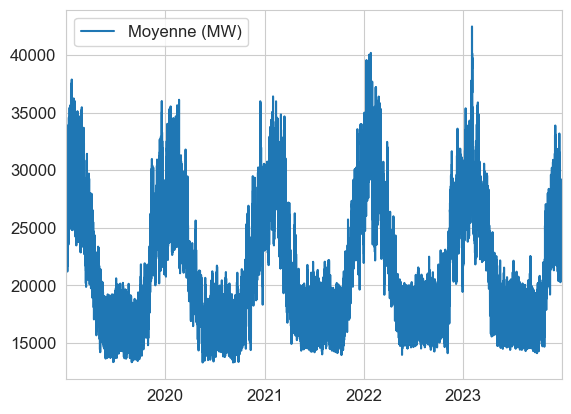

In [48]:
df.plot()
plt.show()

<Axes: >

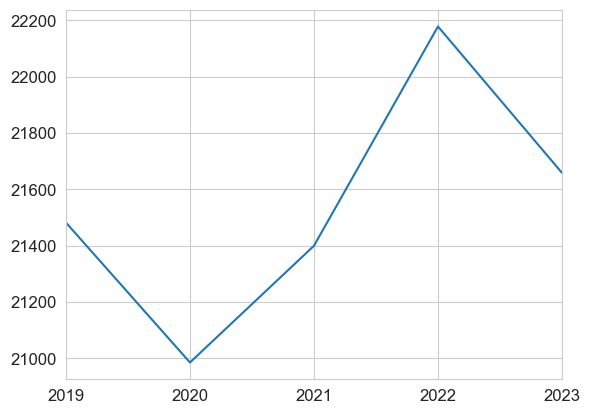

In [49]:
df[column_selection].resample(rule='A').mean().plot()

<Axes: >

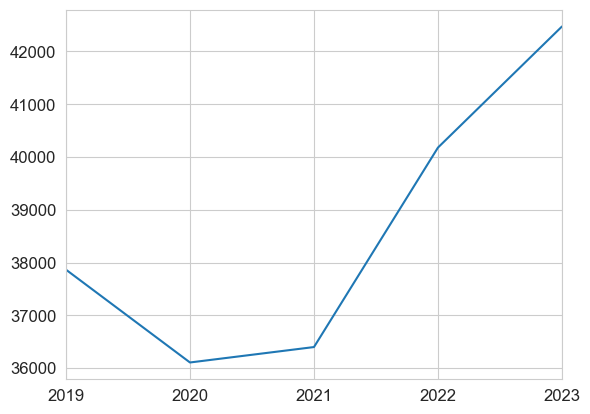

In [50]:
df[column_selection].resample(rule='A').max().plot()

<Axes: >

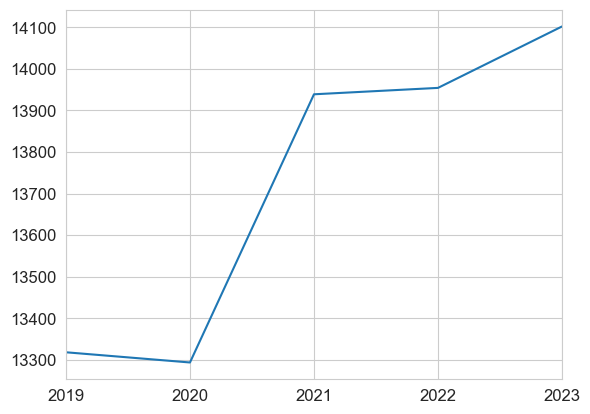

In [51]:
df[column_selection].resample(rule='A').min().plot()

No outlier detected, no adjustment in the data is necessary.

Extraction of the date for holidays.

In [52]:
df1=df.copy()
df1["Date"] = df1.index.date
df1

,Moyenne (MW),Date
2019-01-01 01:00:00,23762.55,2019-01-01
2019-01-01 02:00:00,23830.23,2019-01-01
2019-01-01 03:00:00,23608.07,2019-01-01
2019-01-01 04:00:00,23562.48,2019-01-01
2019-01-01 05:00:00,23546.16,2019-01-01
...,...,...
2023-12-31 19:00:00,28620.17,2023-12-31
2023-12-31 20:00:00,27841.33,2023-12-31
2023-12-31 21:00:00,27101.44,2023-12-31
2023-12-31 22:00:00,26577.01,2023-12-31


# Holidays

Holidays are important in time series forecasting as they often affect the data values on those days. Therefore, a new column is added to the dataset to state whether each day was holiday or not.

In [53]:
import holidays

qc_holidays = holidays.Canada(prov='QC')

# Ensure 'Date' column is in datetime format
df1['Date'] = pd.to_datetime(df1['Date'])

# Extract unique dates from the "Date" column
unique_dates = df1['Date'].unique()

# Create a dictionary to map each unique date to 1 if it's a holiday, 0 otherwise
holiday_dict = {date: 1 if date in qc_holidays else 0 for date in unique_dates}

# Map the dictionary to the original DataFrame to create the "holidays" column
df1['is_holiday'] = df1['Date'].map(holiday_dict)

In [54]:
df1.head()

,Moyenne (MW),Date,is_holiday
2019-01-01 01:00:00,23762.55,2019-01-01,1
2019-01-01 02:00:00,23830.23,2019-01-01,1
2019-01-01 03:00:00,23608.07,2019-01-01,1
2019-01-01 04:00:00,23562.48,2019-01-01,1
2019-01-01 05:00:00,23546.16,2019-01-01,1


# Feature creation

The new features consists of different bits of information "already stored" in the date, such as the day of the week and the day of the year. Given the seasonality of the time series data, these features might lead to more accurate predictions.

In [55]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["Hour"] = df.index.hour # Hour extraction
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df

In [56]:
df2 = create_features(df1)
df2.head()

,Moyenne (MW),Date,is_holiday,Hour,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year
2019-01-01 01:00:00,23762.55,2019-01-01,1,1,1,1,1,1,1,2019,1
2019-01-01 02:00:00,23830.23,2019-01-01,1,2,1,1,1,1,1,2019,1
2019-01-01 03:00:00,23608.07,2019-01-01,1,3,1,1,1,1,1,2019,1
2019-01-01 04:00:00,23562.48,2019-01-01,1,4,1,1,1,1,1,2019,1
2019-01-01 05:00:00,23546.16,2019-01-01,1,5,1,1,1,1,1,2019,1


Add 1-7 hours back lagged values

In [57]:
df2[f'{column_selection}_1hourback']=df2[f'{column_selection}'].shift(+1)
df2[f'{column_selection}_2hourback']=df2[f'{column_selection}'].shift(+2)
df2[f'{column_selection}_3hourback']=df2[f'{column_selection}'].shift(+3)
df2[f'{column_selection}_4hourback']=df2[f'{column_selection}'].shift(+4)
df2[f'{column_selection}_5hourback']=df2[f'{column_selection}'].shift(+5)
df2[f'{column_selection}_6hourback']=df2[f'{column_selection}'].shift(+6)
df2[f'{column_selection}_7hourback']=df2[f'{column_selection}'].shift(+7)

In [58]:
df2 = df2.dropna()
df2.head()

,Moyenne (MW),Date,is_holiday,Hour,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,Moyenne (MW)_1hourback,Moyenne (MW)_2hourback,Moyenne (MW)_3hourback,Moyenne (MW)_4hourback,Moyenne (MW)_5hourback,Moyenne (MW)_6hourback,Moyenne (MW)_7hourback
2019-01-01 08:00:00,24190.08,2019-01-01,1,8,1,1,1,1,1,2019,1,24022.19,23752.90,23546.16,23562.48,23608.07,23830.23,23762.55
2019-01-01 09:00:00,24071.91,2019-01-01,1,9,1,1,1,1,1,2019,1,24190.08,24022.19,23752.90,23546.16,23562.48,23608.07,23830.23
2019-01-01 10:00:00,23821.15,2019-01-01,1,10,1,1,1,1,1,2019,1,24071.91,24190.08,24022.19,23752.90,23546.16,23562.48,23608.07
2019-01-01 11:00:00,23606.33,2019-01-01,1,11,1,1,1,1,1,2019,1,23821.15,24071.91,24190.08,24022.19,23752.90,23546.16,23562.48
2019-01-01 12:00:00,23826.04,2019-01-01,1,12,1,1,1,1,1,2019,1,23606.33,23821.15,24071.91,24190.08,24022.19,23752.90,23546.16


# Data analysis

For historical load data, a strong autocorrelation pattern should be observed if the data is faithful to reality. 

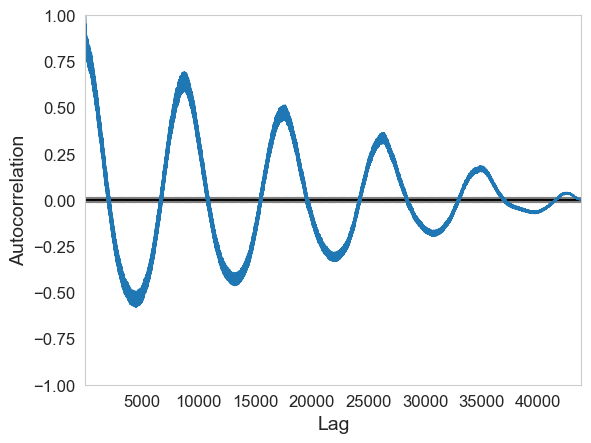

In [59]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df2[column_selection])
plt.show()

ADF test to check for stationarity.

In [60]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df2[column_selection] , autolag= 'AIC')
print("1. ADF :" , dftest[0])
print("2. P-Value :" , dftest[1])
print("3. Num of lags :" , dftest[2])
print("4. No of obs used for ADF regression and critical value calculation :" , dftest[3])
print("5. Critical Values: ")
for key, val in dftest[4].items():
    print("\t",key, ": " , val)

1. ADF : -5.615606292935391
2. P-Value : 1.1763420866087258e-06
3. Num of lags : 55
4. No of obs used for ADF regression and critical value calculation : 43760
5. Critical Values: 
	 1% :  -3.4304994443243553
	 5% :  -2.861606051114624
	 10% :  -2.5668051568599415


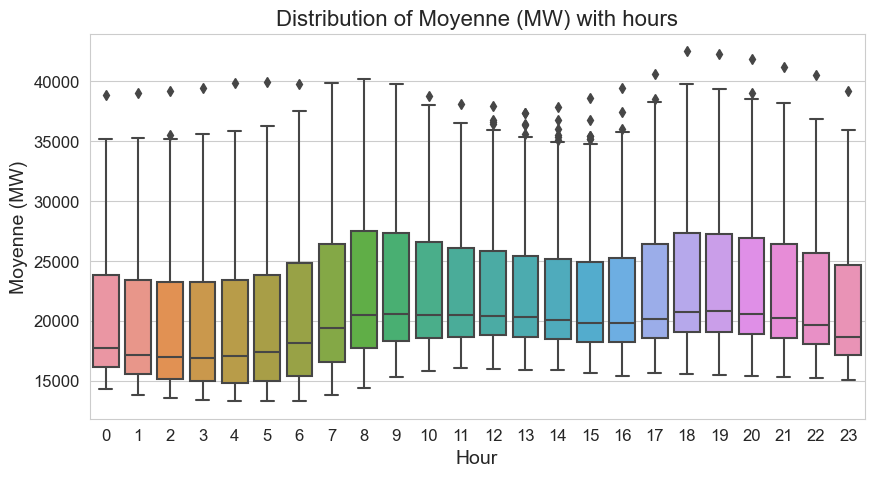

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x="Hour", y=column_selection, data=df2)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24))
ax.set_xlabel("Hour")
ax.set_ylabel(column_selection)
ax.set_title(f"Distribution of {column_selection} with hours");

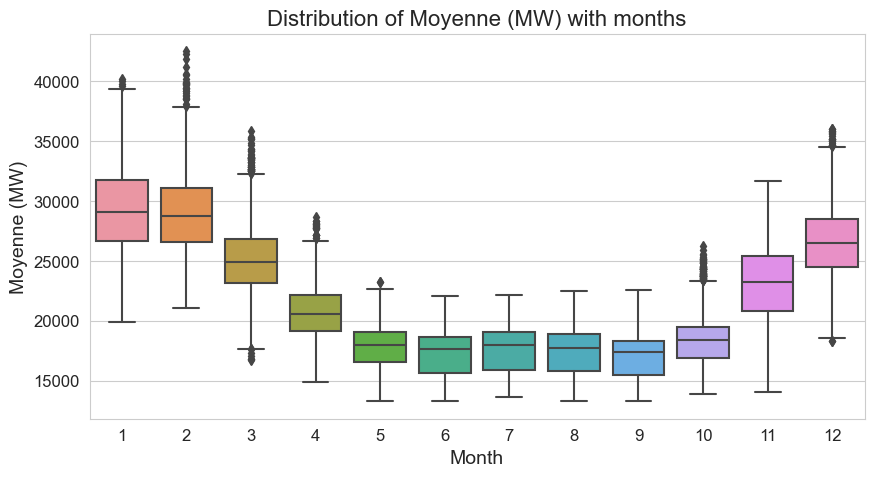

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x="month", y=column_selection, data=df2)
ax.set_xlabel("Month")
ax.set_ylabel(column_selection)
ax.set_title(f"Distribution of {column_selection} with months");

It seems that the lowest consumption occurs during the summer months.

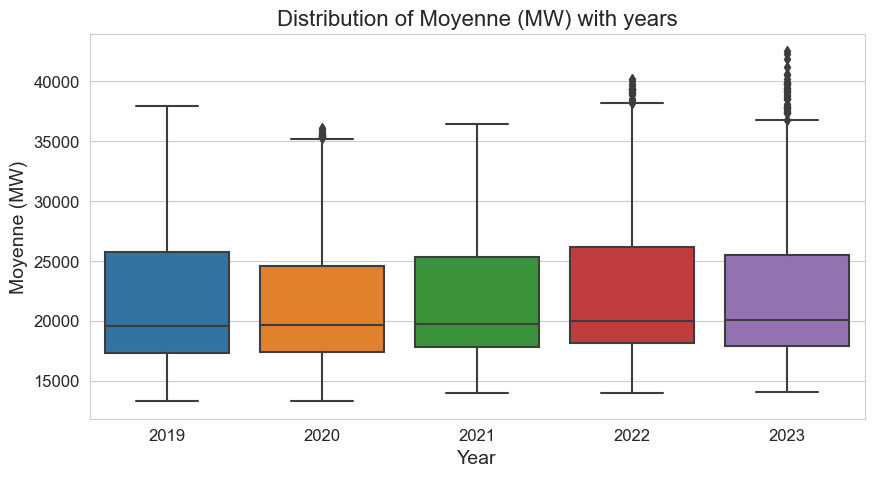

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x="year", y=column_selection, data=df2)

ax.set_xlabel("Year")
ax.set_ylabel(column_selection)
ax.set_title(f"Distribution of {column_selection} with years");

No apparent trend in the electricity consumption.

# Train-Test Split

In [64]:
threshold_date_1 = "01-01-2023"

train_data = df2.loc[df2.index < threshold_date_1]
test_data = df2.loc[df2.index >= threshold_date_1]

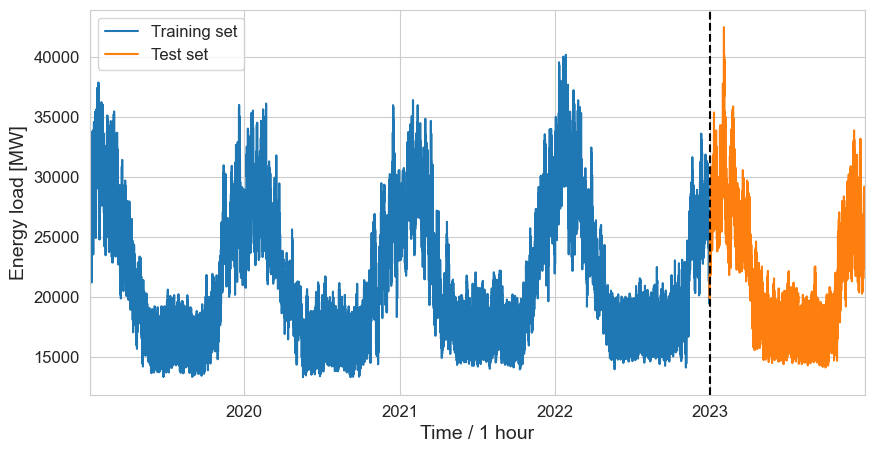

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))
train_data[column_selection].plot(ax=ax, label="Training set")
test_data[column_selection].plot(ax=ax, label="Test set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.set_xlabel("Time / 1 hour")
ax.set_ylabel("Energy load [MW]")
plt.legend();

Features are selected and added, with the target variable, to create the train and test data.

In [66]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "Hour",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "week_of_year",
    "Moyenne (MW)_1hourback",
    "Moyenne (MW)_2hourback",
    "Moyenne (MW)_3hourback",
    "Moyenne (MW)_4hourback",
    "Moyenne (MW)_5hourback",
    "Moyenne (MW)_6hourback",
    "Moyenne (MW)_7hourback"
]
TARGET = column_selection

In [67]:
FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

# Model training

In [68]:
lin_model=LinearRegression()
ran_model=RandomForestRegressor(random_state=1)
xg_model = XGBRegressor()

# Separate features and target
X_train = train_data_keras.iloc[:, :-1]
y_train = train_data_keras.iloc[:, -1]
X_test = test_data_keras.iloc[:, :-1]
y_test = test_data_keras.iloc[:, -1]

# Convert to NumPy arrays
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [69]:
ran_model.fit(X_train,y_train)

RandomForestRegressor(random_state=1)

In [70]:
lin_model.fit(X_train,y_train)

LinearRegression()

In [71]:
xg_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Data scaling for the LSTM model.

In [72]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(FEATURES))
)
y_train_keras = train_data_keras_s[:,-1]

X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(FEATURES))
)
y_test_keras = test_data_keras_s[:,-1]

The LSTM is created, compiled and fit on the training data. 

In [73]:
# Define the input shape
input_shape = (X_train_keras.shape[1], X_train_keras.shape[2])

# Create and compile neural network
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(32))
model.add(Dropout(0.25))

model.add(Dense(1))

model.compile(loss = "mse", optimizer="adam")

C:\Users\Chris\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
# Fit model
history = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=25,
    batch_size=32,
    #validation_data=(X_hold_out_keras, y_hold_out_keras),
    #callbacks=[early_stopping, reduce_lr_loss]
)

Epoch 1/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0119
Epoch 2/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0017
Epoch 3/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0011
Epoch 4/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.8714e-04
Epoch 5/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.0958e-04
Epoch 6/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.6869e-04
Epoch 7/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.1448e-04
Epoch 8/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.9900e-04
Epoch 9/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.9644e-04
Epoch 10/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.8194e-04
Epoch 11/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6059e-04
Epoch 12/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.8600e-04
Epoch 13/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.6059e-04
Epoch 14/25
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lo

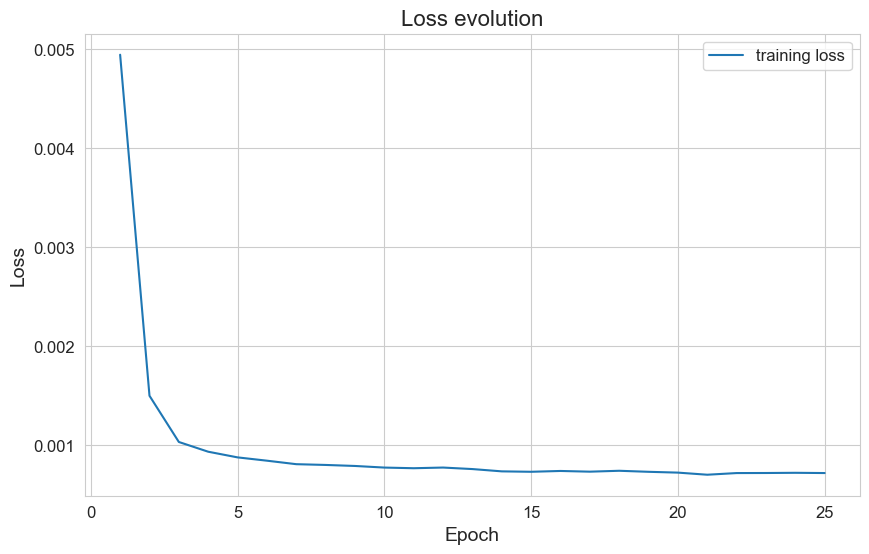

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

# Predictions

In [76]:
ran_pred=ran_model.predict(X_test)
lin_pred=lin_model.predict(X_test)
xg_pred = xg_model.predict(X_test)

Calculations of the performance metrics.

In [77]:
MAPE_RF = round((mean_absolute_percentage_error(ran_pred[:],y_test[:])*100),2)
R2_RF = round(r2_score(y_test[:], ran_pred[:]), 2)

MAPE_LR = round((mean_absolute_percentage_error(lin_pred[:],y_test[:])*100),2)
R2_LR = round(r2_score(y_test[:], lin_pred[:]), 2)

MAPE_XG= round((mean_absolute_percentage_error(y_test[:],xg_pred[:])*100),2)
R2_XG = round(r2_score(y_test[:], xg_pred[:]), 2)

Results of the RF, LR and XGB models.

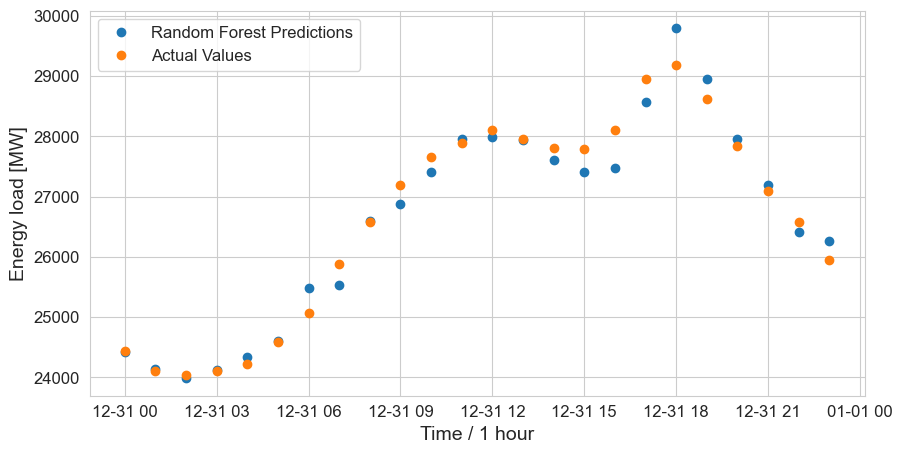

In [78]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(test_data_keras.index[-24:], ran_pred[-24:], "o", label='Random Forest Predictions')
plt.plot(test_data_keras.index[-24:], y_test[-24:],  "o", label='Actual Values')
plt.legend(loc="upper left")
plt.ylabel("Energy load [MW]")
plt.xlabel("Time / 1 hour")
plt.show()

In [79]:
print('MAPE for Random Forest Model is:',MAPE_RF)
print('R^2 for Random Forest Model is:',R2_RF)

MAPE for Random Forest Model is: 0.72
R^2 for Random Forest Model is: 1.0


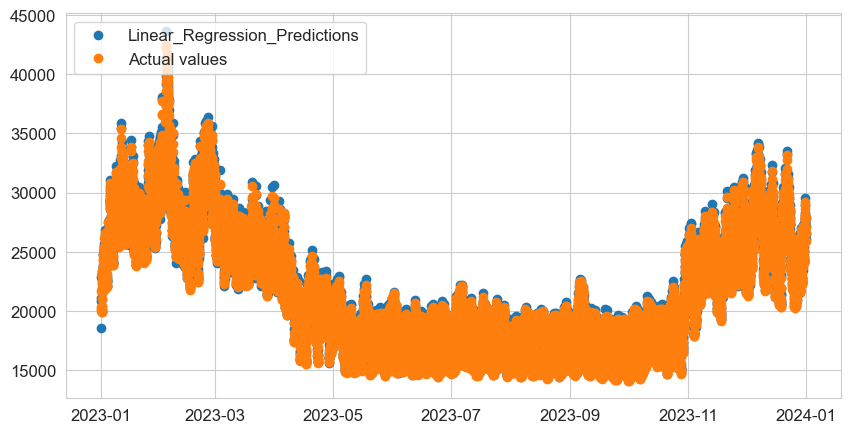

In [80]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(test_data_keras.index, lin_pred,  "o", label='Linear_Regression_Predictions')
plt.plot(test_data_keras.index, y_test,  "o", label='Actual values')
plt.legend(loc="upper left")
plt.show()

In [81]:
print('MAPE for Linear Regression Model is:',MAPE_LR)
print('R^2 for Linear Regression Model is:',R2_LR)

MAPE for Linear Regression Model is: 1.19
R^2 for Linear Regression Model is: 1.0


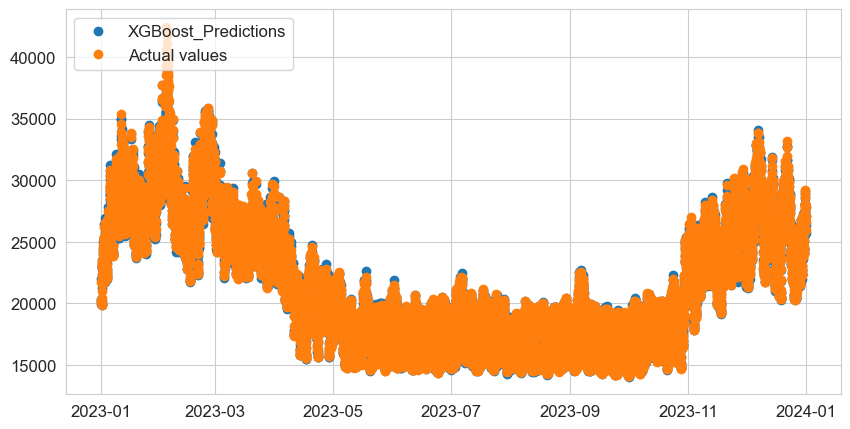

In [83]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(test_data_keras.index, xg_pred,  "o", label='XGBoost_Predictions')
plt.plot(test_data_keras.index, y_test,  "o", label='Actual values')
plt.legend(loc="upper left")
plt.show()

In [84]:
print('MAPE for XG Boost Model is:',MAPE_XG)
print('R2 for XG Boost Model is:',R2_XG)

MAPE for XG Boost Model is: 0.72
R2 for XG Boost Model is: 1.0


Prediction of the LSTM and inverse scaling.

In [85]:
# Prediction on test set
pred_lstm = model.predict(X_test_keras)
# Inverse transform the prediction
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [86]:
y_test = test_data[TARGET]
result_frame=y_test.to_frame()
result_frame["pred_lstm"] = results_lstm[:,-1]

In [87]:
result_frame

,Moyenne (MW),pred_lstm
2023-01-01 00:00:00,21731.32,20394.316608
2023-01-01 01:00:00,20300.10,22112.701124
2023-01-01 02:00:00,20176.26,19492.399957
2023-01-01 03:00:00,20010.46,19961.168425
2023-01-01 04:00:00,19887.90,20223.805233
...,...,...
2023-12-31 19:00:00,28620.17,28988.057182
2023-12-31 20:00:00,27841.33,27940.785378
2023-12-31 21:00:00,27101.44,27190.451042
2023-12-31 22:00:00,26577.01,26577.892222


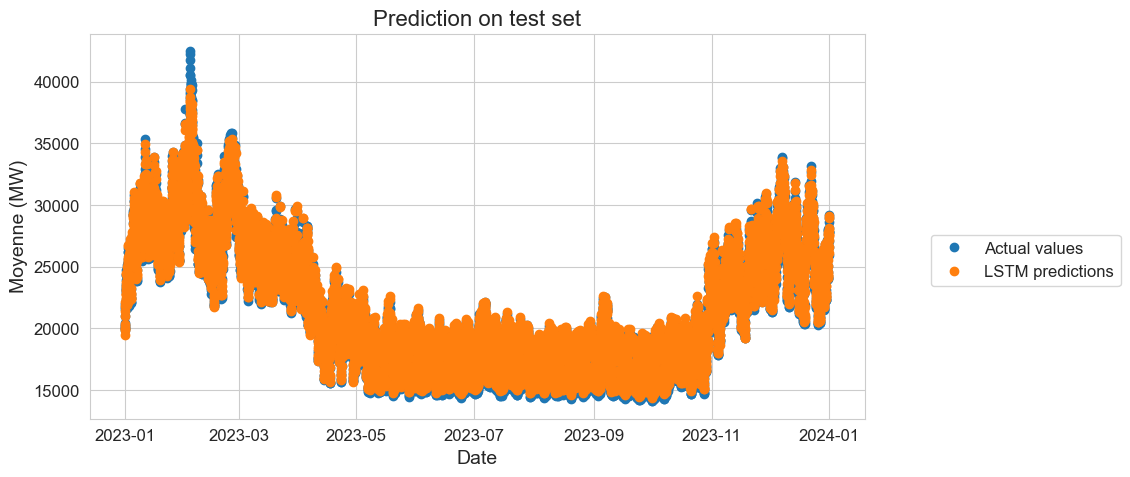

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(result_frame.index, result_frame[column_selection], "o", label="Actual values")
ax.plot(result_frame.index, result_frame["pred_lstm"], "o", label="LSTM predictions")

ax.legend(loc="upper left", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel(f"{column_selection}")
ax.set_xlabel("Date");

In [89]:
mape = mean_absolute_percentage_error(result_frame[column_selection], result_frame["pred_lstm"])*100
print("MAPE of the LSTM model is: %.2f" % mape)
R2_lstm = r2_score(result_frame[column_selection], result_frame["pred_lstm"])
print("R^2 for LSTM model is: %.2f" % R2_lstm)

MAPE of the LSTM model is: 1.31
R^2 for LSTM model is: 0.99
